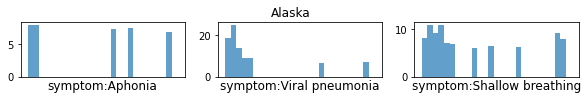

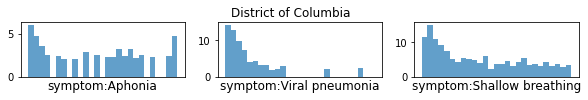

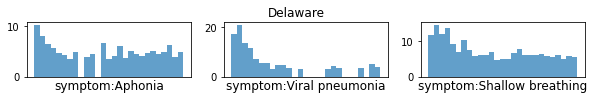

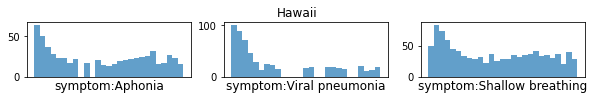

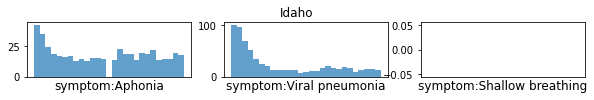

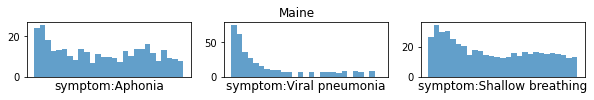

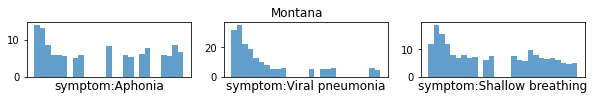

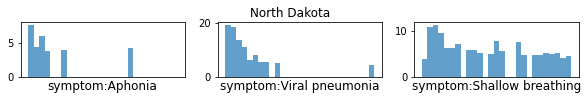

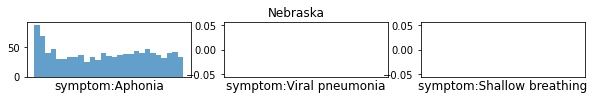

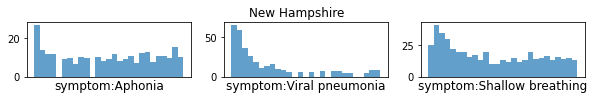

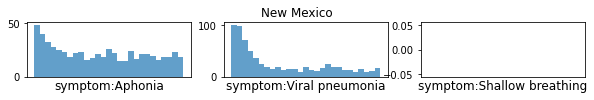

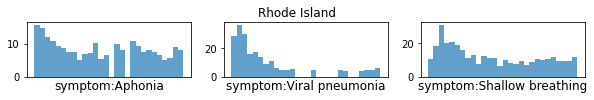

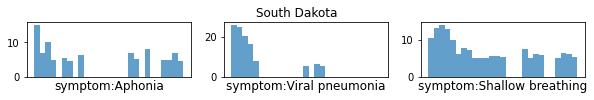

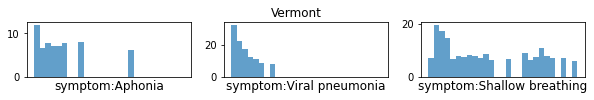

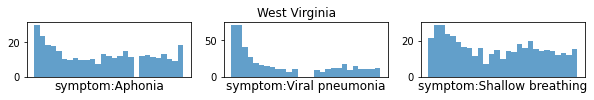

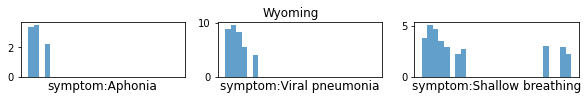

In [26]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

df = pd.read_csv('result.csv')
df.iloc[:, 3:] = df.iloc[:, 3:].apply(pd.to_numeric)
df = df.fillna(0)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
symptoms = pd.DataFrame(df[df.columns[3:-1]].sum(axis=0), columns=['sum']).\
    sort_values(by=['sum'], ascending=False).head(15).index.values
regions = df.region_name.unique()


for region in regions:
    plt.figure(figsize=(10,1))
    plt.figure(1)
    data = df.loc[df['region_name'] == region][np.append(symptoms, 'date')]
    for i in range(1,4):
        ax = plt.subplot(1,3,i)
        ax.bar(data.date, data.iloc[:, i-1], alpha=0.7, width=7)
        ax.set_title(symptoms[i-1], y=-0.35)
        ax.set_xticks([])
    plt.suptitle(region, y=1.1)
    plt.show()

0      44.088368
1     904.654418
2     881.050916
3     664.786010
4     504.359141
5     363.112604
6     291.861488
7     252.902482
8     213.851512
9     188.838423
10    173.105728
11    117.099305
12     85.009020
13     94.014015
14    102.532268
15    128.201962
16    106.456250
17    122.462045
18    177.293139
19    175.940753
20    171.036573
21    186.087189
22    153.891221
23    148.004109
24    175.249827
25    173.584167
26    217.753119
27    218.916392
Name: 0, dtype: float64


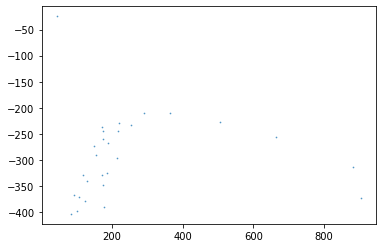

In [104]:
data = result.iloc[:, 1:]
u, s, vt = np.linalg.svd(data-np.mean(data,0))
pcs = data @ vt.T
print(pcs.iloc[:,0])
plt.scatter(pcs.iloc[:,0], pcs.iloc[:,1], s=.5, alpha=.7)
plt.show()